In [1]:
from firedrake import *
from firedrake.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

In [2]:
m = Mesh("../meshes/ITER.msh", dim = 2, distribution_parameters={"partition": False}, reorder = True)
m.init()

### Extract nodes of a subregion:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


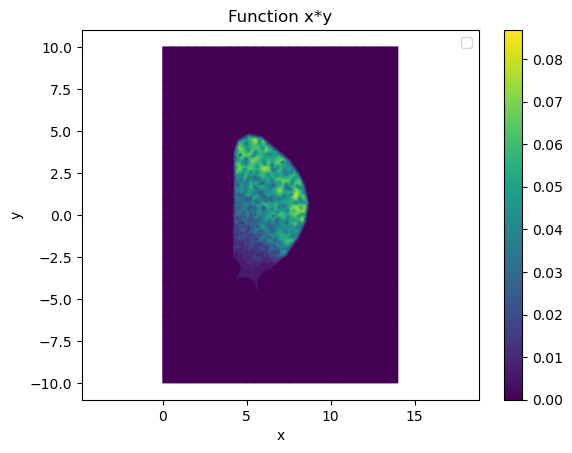

In [7]:
V = FunctionSpace(m,"CG",1)

v = TestFunction(V)
vacuum_marker = assemble(v * dx(subdomain_id=2))

limiter_dofs = DirichletBC(V,0.0,16).nodes
vacuum_marker.dat.data[limiter_dofs] = 0.0

fig, ax = plt.subplots()
fig.colorbar(tripcolor(vacuum_marker, axes=ax))
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

(array([  77,   86,   94, ..., 2594, 2595, 2596]),)

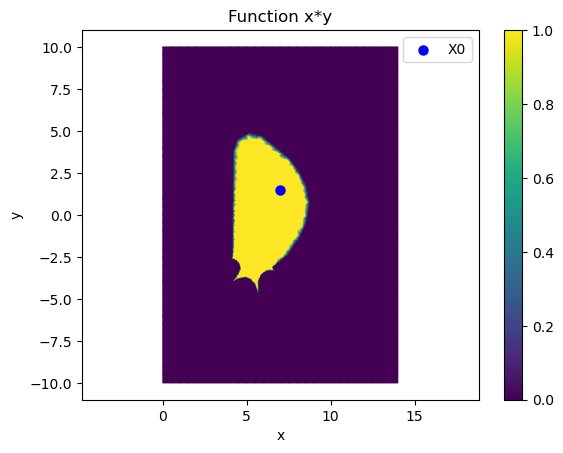

In [39]:
dofs_in_vacuum = np.where(vacuum_marker.dat.data_ro > 0.0)
display(dofs_in_vacuum)

# test if it worked:
f = Function(V)
f.dat.data[dofs_in_vacuum] = 1

# Identify a point inside the vacuum region to have a candidate magnetic axis:
#idx  = dofs_in_vacuum[np.argmin(f.dat.data_ro[dofs_in_vacuum])]
idx = dofs_in_vacuum[0][len(dofs_in_vacuum[0]) // 5]  # Take the middle index for simplicity
coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
x0 = coord_func.dat.data_ro[idx]

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
ax.scatter(x0[0], x0[1], color='blue', linewidth=1.5, label='X0')
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
dofs_in_vacuum[np.argmax(vacuum_marker.dat.data_ro[dofs_in_vacuum])]

In [5]:
# Check if limiter nodes are contained:
#limiter_dofs = DirichletBC(V,0.0,16).nodes
display(f.dat.data_ro[limiter_dofs])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [6]:
display(dofs_in_vacuum)
display(dofs_in_vacuum[0])

(array([  77,   86,   94, ..., 2594, 2595, 2596]),)

array([  77,   86,   94, ..., 2594, 2595, 2596])

### Algorithm to find X-points:

In [3]:
def build_dof_connectivity_map(V):
    # Builds two maps that to access from each node the neighboring cells and the nodes at their vertices (neighboring nodes)
    # param: V - function space

    # return dof_cell_map_arrays: A list containing at the i-esim position an array with the indexes of the cells that have the i-esim node as a vertex.
    # return neighbor_map_arrays: A list containing at the i-esim position an array containg the indexes of the neighboring nodes of the i-esim dof, sorted counterclockwise

    n_dofs = V.dof_count
    neighbors_map = [set() for _ in range(n_dofs)]  # list of set
    dof_cell_map =  [set() for _ in range(n_dofs)]

    cell_dofs = V.cell_node_map().values
    for cell_idx, cell in enumerate(cell_dofs):
        for i in range(len(cell)):
            # Fill dof_cell_map:
            dof1 = cell[i]
            dof_cell_map[dof1].add(cell_idx)
            # Fill neighbors map:
            for j in range(i+1,len(cell)):
                dof2 = cell[j]
                neighbors_map[dof1].add(dof2)
                neighbors_map[dof2].add(dof1)

    # Convert into lists of arrays:
    dof_cell_map_arrays = []
    neighbors_map_arrays = []

    m = V.mesh()
    coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))

    for idx, neighbors_set in enumerate(neighbors_map):

        neighbors_array = np.array(list(neighbors_set))
        dof_cell_map_arrays.append(np.array(list(dof_cell_map[idx])))

        # Order (counter-clockwise) neighboring dofs order:
        node_coords = coord_func.dat.data_ro[idx]
        neighbor_coords = coord_func.dat.data_ro[neighbors_array]

        dx = neighbor_coords[:, 0] - node_coords[0]
        dy = neighbor_coords[:, 1] - node_coords[1]
        angles = np.arctan2(dy, dx)

        sorted_indices = np.argsort(angles)
        neighbors_map_arrays.append(neighbors_array[sorted_indices])

    return neighbors_map_arrays, dof_cell_map_arrays

In [ ]:
def build_neighbors_map(V):
    '''
        Builds two maps that to access from each node the neighboring cells and the nodes at their vertices (neighboring nodes)
        param: V - function space

        return: neighbor_map_sorted: A list containing at the i-esim position an array containg the indexes of the neighboring nodes of the i-esim dof, sorted counterclockwise
    '''
    n_dofs = V.dof_count
    neighbors_map = [set() for _ in range(n_dofs)]  # list of set

    cell_dofs = V.cell_node_map().values
    for cell in cell_dofs:
        for i in range(len(cell)):
            dof1 = cell[i]
            for j in range(i+1,len(cell)):
                dof2 = cell[j]
                neighbors_map[dof1].add(dof2)
                neighbors_map[dof2].add(dof1)

    # Order (counter-clockwise) neighbors order:
    neighbors_map_sorted = []
    m = V.mesh()
    coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))

    for idx, neighbors_set in enumerate(neighbors_map):
        neighbors_array = np.array(list(neighbors_set))

        node_coords = coord_func.dat.data_ro[idx]
        neighbor_coords = coord_func.dat.data_ro[neighbors_array]

        dx = neighbor_coords[:, 0] - node_coords[0]
        dy = neighbor_coords[:, 1] - node_coords[1]
        angles = np.arctan2(dy, dx)

        sorted_indices = np.argsort(angles)
        neighbors_map_sorted.append(neighbors_array[sorted_indices])

    return neighbors_map_sorted

In [5]:
def is_saddle_point(f, idx, neighbors_map):
    # Check if the node indicated with idx is a saddle point for the function f
    # param f: function
    # param idx: index of the mesh node to be checked.
    # param neighbors_map: list that associates to a node an array with the indexes of the neighboring nodes

    neighbors_idx = neighbors_map[idx] 
    if len(neighbors_idx) < 4:
        return False

    # If grad changes sign at least 4 times, f has a saddle point in dof[idx]:
    f_node = f.dat.data_ro[idx]
    f_neighbors = f.dat.data_ro[neighbors_idx]
    grad_signs = np.sign(f_neighbors - f_node)

    # Eliminate zeros to count the number of sign changes:
    for i in range(len(grad_signs)):
        if grad_signs[i] == 0:
            grad_signs[i] = grad_signs[i-1] if i > 0 else grad_signs[-1]

    counter = 0
    for i in range(len(grad_signs)):
        next_i = (i + 1) % len(grad_signs)
        if grad_signs[i] * grad_signs[next_i] < 0:
            counter += 1

    return counter > 3    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


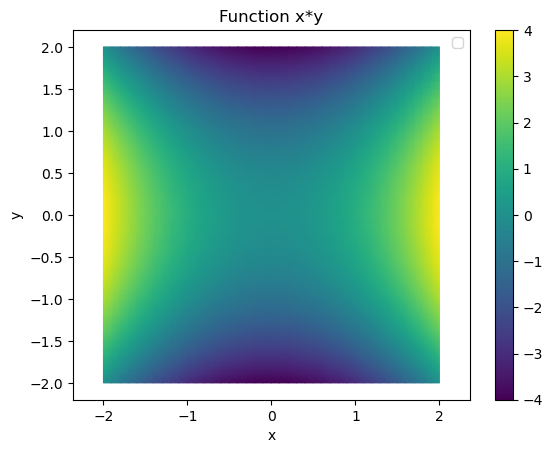

In [6]:
# Test:
m = RectangleMesh(20, 20, 2.0, 2.0, -2.0, -2.0)
V = FunctionSpace(m, "CG", 1)
    
# z = x*y has saddle point in (0,0))
x, y = SpatialCoordinate(m)
f = Function(V).interpolate(x**2 - y**2)

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [7]:
neighbors_map = build_neighbors_map(V)
    
# Find closest node to the origin:
coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
dof_coords = coord_func.dat.data_ro[:]
distances = np.sum(dof_coords**2, axis=1)
center_node = np.argmin(distances)

print(f"Closest node to origin: {center_node}")
print(f"Coordinates: {dof_coords[center_node]}")
print(f"Function value:: {f.dat.data_ro[center_node]:.6f}")
    
is_saddle = is_saddle_point(f, center_node, neighbors_map)
print(f"Is a saddle point? {is_saddle}")

neighbors = neighbors_map[center_node]
f_center = f.dat.data_ro[center_node]
f_neighbors = f.dat.data_ro[neighbors]
print(f"Neighbor values: {f_neighbors}")
print(f"Differences: {f_neighbors - f_center}")

Closest node to origin: 219
Coordinates: [0. 0.]
Function value:: 0.000000
Is a saddle point? True
Neighbor values: [-4.00000000e-02  8.79851747e-17  4.00000000e-02 -4.00000000e-02
 -9.10382880e-17  4.00000000e-02]
Differences: [-4.00000000e-02  8.79851747e-17  4.00000000e-02 -4.00000000e-02
 -9.10382880e-17  4.00000000e-02]


### Identify intersections of the plasma boundary with edges

In [ ]:
def vacuum_region_nodes(m,vacuum_tag):
    '''
        Extract the nodes that lie in the vacuum region inside the limiter.
    '''
    return 0


In [8]:
def identify_psi0(psi, neighbors_map, limiter_tag):
    
    V = psi.function_space()

    # limiter nodes -> DA SPOSTARE COME OGGETTO DELLA CLASSE NEL COSTRUTTORE
    limiter_nodes = DirichletBC(V, 0.0, limiter_tag).nodes
    psi0 = max(psi.dat.data[limiter_nodes])

    # Extract nodes s.t. psi>psi0
    psi_data = psi.dat.data_ro[:]
    internal_dof_idx = np.where(psi_data > psi0)[0] 

    # Identify saddle points inside the region psi>psi0
    saddle_points = []
    for idx in internal_dof_idx:
        if is_saddle_point(psi, idx, neighbors_map):
            saddle_points.append(idx)
    saddle_points = np.array(saddle_points)

    # Update psi0 if there is an X-points configuration:
    if len(saddle_points) > 0:
        psi0 = max(psi.dat.data_ro[saddle_points])
    return psi0

Ora manca da modificare compute intersections per "tagliare fuori" i rami della parte non chiusa della separatrix

In [9]:
def interpolate_edge(p1, p2, v1, v2, c):
    t = (c - v1) / (v2 - v1)
    return (1 - t) * p1 + t * p2

In [46]:
def compute_intersections(f,c,neighbors_map,idx,saddle_points = []):

    V = f.function_space()
    mesh = V.mesh()

    # DOF coordinates:
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]
    f_vals = f.dat.data_ro[:]

    # === Trova intersezioni f = c su edge
    intersections = []
    queue = {idx}
    visited = set()

    while queue:

        dof = queue.pop()
        visited.add(dof)    

        p1 = dof_coords[dof]
        f1 = f_vals[dof]

        for neighbor in neighbors_map[dof]:

            if neighbor in visited:
                continue

            f2 = f_vals[neighbor]
            if (f1 - c) * (f2 - c) <= 0:  # cambio di segno ⇒ intersezione
                p2 = dof_coords[neighbor]
                pt = interpolate_edge(p1, p2, f1, f2, c)
                intersections.append(pt)
            elif neighbor in saddle_points:
                # because "visited" at the end of the loop is the set of dofs inside inside the contour line
                # so even if the saddle point it is not actually visited, it is added to include in the set
                # of dofs inside the plasma boundary
                visited.add(neighbor)
                continue
            else:
                queue.add(neighbor)

    return np.array(intersections), np.array(list(visited))

#### Test con X-point:

In [36]:
def compute_intersections_OLD_VERSION(f,c):

    V = f.function_space()
    mesh = V.mesh()

    # === Coordinate dei DOF
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]
    f_vals = f.dat.data_ro[:]

    # === Ottieni la mappa dei DOF per ogni cella
    cell_dofs = V.cell_node_map().values  # shape (num_cells, 3)

    # === Trova intersezioni f = c su edge
    intersections = []

    for dofs in cell_dofs:
        for i, j in [(0, 1), (1, 2), (2, 0)]:
            vi, vj = dofs[i], dofs[j]
            f1, f2 = f_vals[vi], f_vals[vj]
    
            if (f1 - c) * (f2 - c) <= 0:  # cambio di segno ⇒ intersezione -> ho messo <= !!
                p1, p2 = dof_coords[vi], dof_coords[vj]
                pt = interpolate_edge(p1, p2, f1, f2, c)
                #print(pt)
                intersections.append(pt)
    
    return np.array(intersections)

Chosen point coordinates: [1.4 0. ]


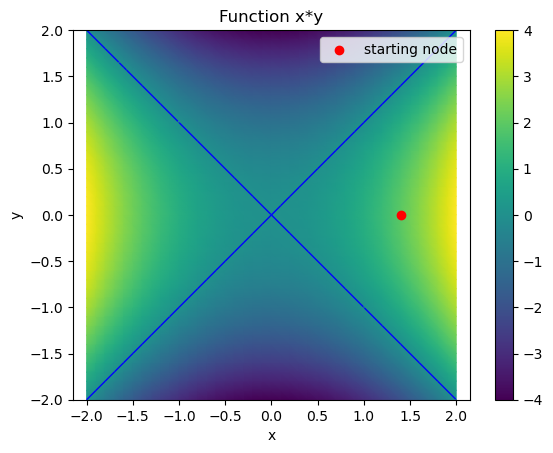

In [47]:
# Test 1:
m = RectangleMesh(20, 20, 2.0, 2.0, -2.0, -2.0)
V = FunctionSpace(m, "CG", 1)
    
# z = x*y has saddle point in (0,0))
x, y = SpatialCoordinate(m)
f = Function(V).interpolate(x**2 - y**2)

# Identify a point in the right side of the "X" contour line:
coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
dof_coords = coord_func.dat.data_ro[:]
for i,p in enumerate(dof_coords):
    if p[1]==0 and p[0]>1.4 and p[0]<1.5:
        idx = i
        pt = p

print(f'Chosen point coordinates: {pt}')

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

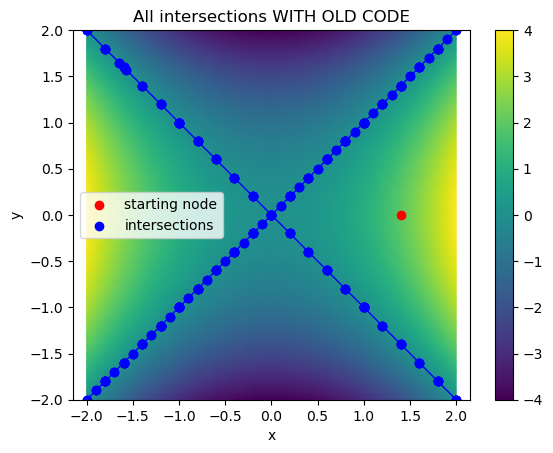

In [48]:
total_intersections = compute_intersections_OLD_VERSION(f,0.0)

# plot:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.scatter(*zip(*total_intersections), color='blue', label='intersections')
plt.title(r"All intersections WITH OLD CODE")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

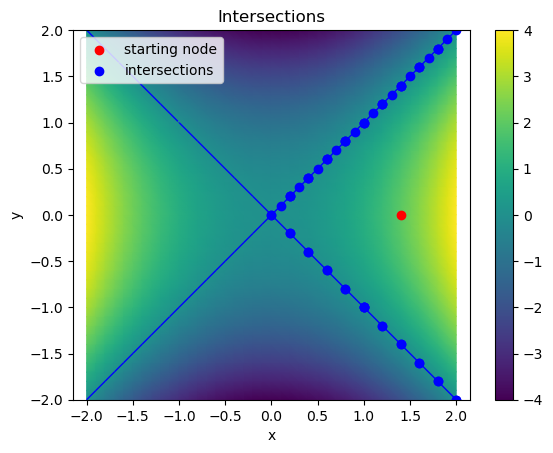

In [49]:
# Try to identify the intersections with f=0 contour line:
neighbors_map = build_neighbors_map(V)
intersections, inside_dofs = compute_intersections(f,0.0,neighbors_map,idx)

# plot:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.scatter(*zip(*intersections), color='blue', label='intersections')
plt.title(r"Intersections")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

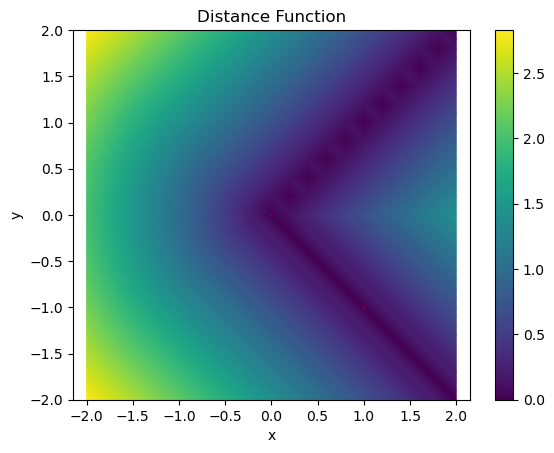

In [50]:
# === Costruisci KDTree per distanze efficienti
tree = cKDTree(intersections)

# === Calcola distanza con segno per ogni punto
unsigned_distance = np.zeros(len(dof_coords))
f_vals = f.dat.data_ro[:]
for i, (pt, f_val) in enumerate(zip(dof_coords, f_vals)):
    dist, _ = tree.query(pt)
    unsigned_distance[i] = dist

# === Crea funzione finale
d = Function(V)
d.dat.data[:] = unsigned_distance

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

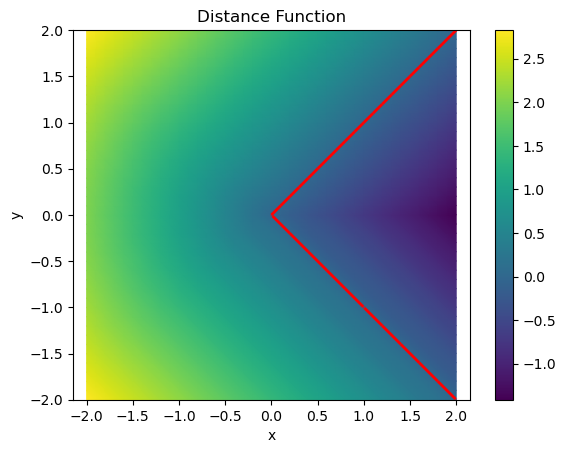

In [51]:
# Convert into signed distance function:
d.dat.data[inside_dofs] *= -1

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

#### Test 2: senza x-points

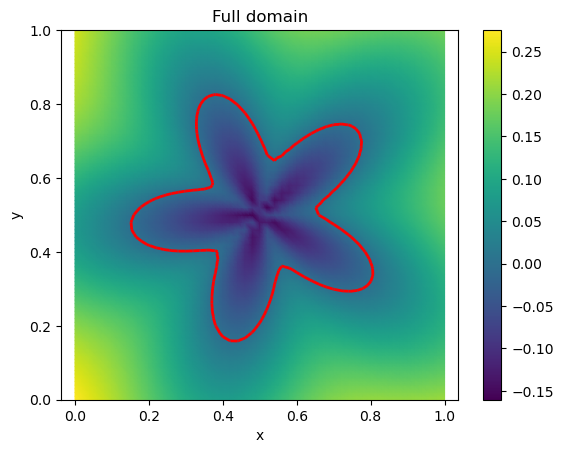

In [52]:
# Test 2:
c = 0  # valore della curva di livello

# === Crea la mesh e lo spazio P1 ===
mesh = UnitSquareMesh(50, 50)
V = FunctionSpace(mesh, "CG", 1)

# === Funzione f ===
x, y = SpatialCoordinate(mesh)
f = Function(V)
#f.interpolate((x-0.5)**2+(y-0.5)**2-0.25**2)
angle = atan2(x-0.5, y-0.5)
f.interpolate(0.5*(sqrt((x-0.5)**2+(y-0.5)**2) - 0.1*cos(5*angle+2.)-0.25))

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[c], colors='red', linewidths=2, axes=ax)
plt.title(r"Full domain")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

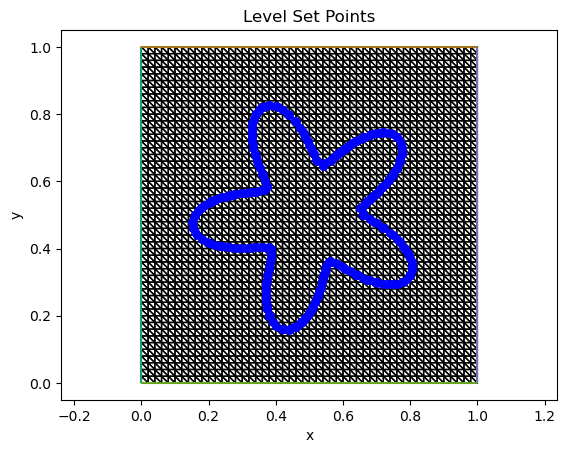

In [53]:
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
dof_coords = coord_func.dat.data_ro[:]
f_vals = f.dat.data_ro[:]

# Identify origin which is inside the contour line:
for i,p in enumerate(dof_coords):
    if p[1]==0 and p[0]==0:
        idx = i
        pt = p

# === calcola i punti di intersezione tra griglia e linea di livello c ====
neighbors_map = build_neighbors_map(V)
level_points, _ = compute_intersections(f,c,neighbors_map,idx)

# === Se non ci sono punti, errore
if len(level_points) == 0:
    raise RuntimeError("Nessun nodo trovato vicino alla curva di livello f = {}".format(c))

lv_pt_x = [pt[0] for pt in level_points]
lv_pt_y = [pt[1] for pt in level_points]
 
fig,ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(lv_pt_x, lv_pt_y, color='blue', linewidths = 0.5)
plt.title(r"Level Set Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

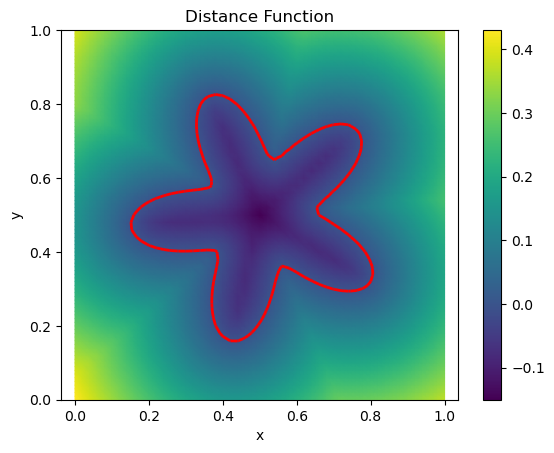

In [54]:
# === Costruisci KDTree per distanze efficienti
tree = cKDTree(level_points)

# === Calcola distanza con segno per ogni punto
signed_distance = np.zeros(len(dof_coords))
for i, (pt, f_val) in enumerate(zip(dof_coords, f_vals)):
    dist, _ = tree.query(pt)
    signed_distance[i] = np.sign(f_val - c) * dist

# === Crea funzione finale
d = Function(V)
d.dat.data[:] = signed_distance

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

#### Test 3: con 2 x-points

Chosen point coordinates: [0. 0.]


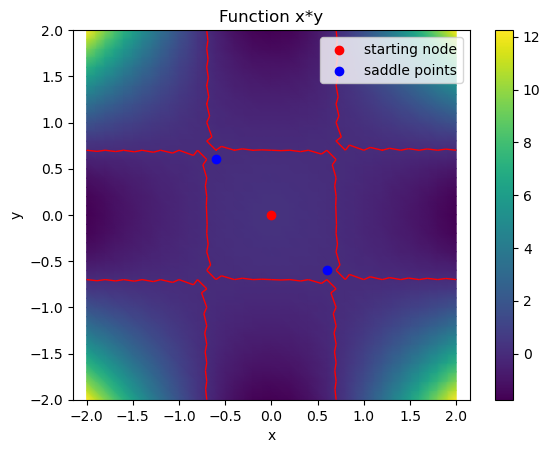

In [55]:
# Test 1:
m = RectangleMesh(20, 20, 2.0, 2.0, -2.0, -2.0)
V = FunctionSpace(m, "CG", 1)
neighbors_map = build_neighbors_map(V)
    
# z = x*y has saddle point in (0,0))
x, y = SpatialCoordinate(m)
f = Function(V).interpolate((x**2-0.5)*(y**2-0.5))

# Identify a point in the right side of the "X" contour line:
coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
dof_coords = coord_func.dat.data_ro[:]
for i,p in enumerate(dof_coords):
    if p[1]==0 and p[0]==0:
        idx = i
        pt = p

print(f'Chosen point coordinates: {pt}')

# Identify saddle points
saddle_points = []
for j in range(V.dof_count):
    if is_saddle_point(f, j, neighbors_map):
        saddle_points.append(j)
saddle_points = np.array(saddle_points)

# Plot
sd_pt_x = [dof_coords[pt][0] for pt in saddle_points]
sd_pt_y = [dof_coords[pt][1] for pt in saddle_points]

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='red', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.scatter(sd_pt_x, sd_pt_y, color='blue', label = 'saddle points')
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

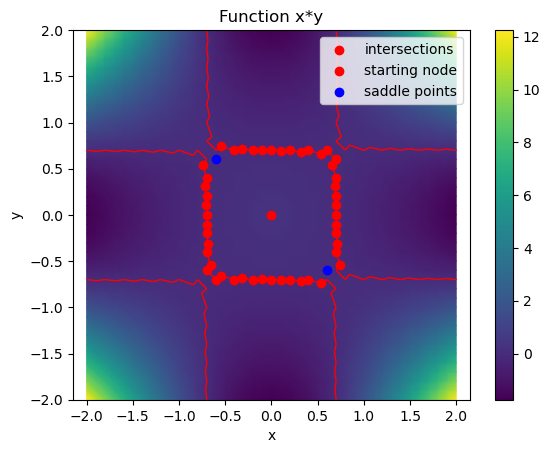

In [56]:
level_points, inside_dofs = compute_intersections(f,c,neighbors_map,idx,saddle_points)

# === Se non ci sono punti, errore
if len(level_points) == 0:
    raise RuntimeError("Nessun nodo trovato vicino alla curva di livello f = {}".format(c))

lv_pt_x = [pt[0] for pt in level_points]
lv_pt_y = [pt[1] for pt in level_points]
 
fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='red', linewidths=1, axes=ax)
plt.scatter(lv_pt_x, lv_pt_y, color='red', label = 'intersections')
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.scatter(sd_pt_x, sd_pt_y, color='blue', label = 'saddle points')
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

/opt/firedrake/firedrake/pyplot/mpl.py:223: UserWarning: No contour levels were found within the data range.
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


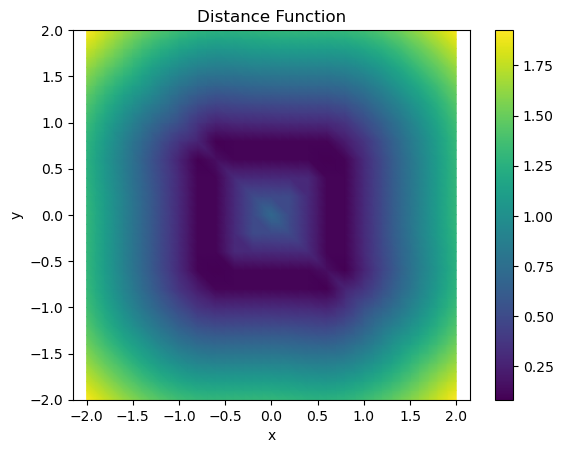

In [57]:
# === Costruisci KDTree per distanze efficienti
tree = cKDTree(level_points)

# === Calcola distanza con segno per ogni punto
signed_distance = np.zeros(len(dof_coords))
for i, (pt, f_val) in enumerate(zip(dof_coords, f_vals)):
    dist, _ = tree.query(pt)
    #signed_distance[i] = np.sign(f_val - c) * dist
    signed_distance[i] = dist

# X signed distance markare i nodi dentro la curva durante l'esplorazione e poi cambiare segno all'unsigned distance in quei nodi

# === Crea funzione finale
d = Function(V)
d.dat.data[:] = signed_distance

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

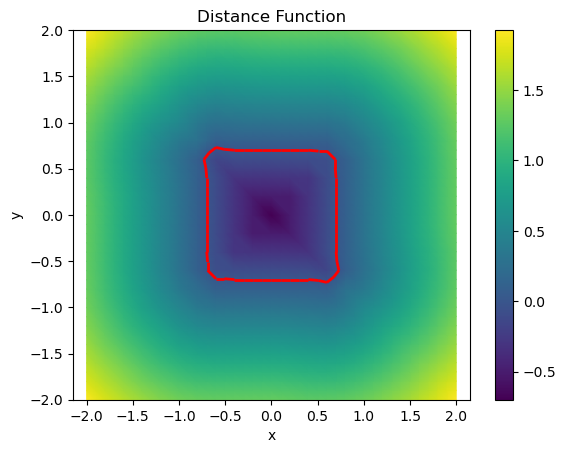

In [58]:
# Convert into signed distance function:
d.dat.data[inside_dofs] *= -1

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

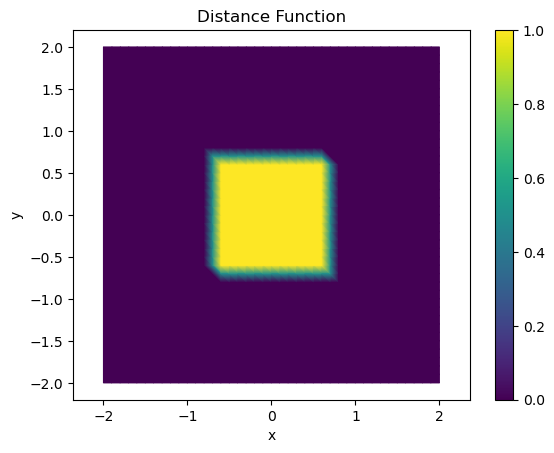

In [71]:
epsilon = 0.01
plasma_mask = Function(V).interpolate(0.5 - 0.5 * tanh(d / epsilon))

fig,ax = plt.subplots()
fig.colorbar(tripcolor(plasma_mask, axes=ax))
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Identify the magnetic axis:

In [ ]:
def magnetic_axis(self, psi_data, idx):
    '''
    Function to compute the magnetic axis position for a given index, using an
    hill-climbing algorithm
    '''
    # psi value at candidate magnetic axis
    psi_ma = psi_data[idx]

    # max psi value amogn neighbors
    neighbors_idx = self.neighbors_map[idx]
    next_idx = neighbors_idx[psi_data[neighbors_idx].argmax()]

    # Stop search if idx is local maximum
    if psi_data[next_idx] > psi_ma:
        self.magnetic_axis(psi_data, next_idx)
    else:
        self.x1_idx = idx
        self.psi_ma = psi_data[idx]